<a href="https://colab.research.google.com/github/jeyakumar-nanc/CS634-DataMining/blob/main/BTC_Deep_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BTC Deep Forecasting**

Install tweepy,yahoo financials, facebook prophet libraries

In [1]:
!pip install tweepy
!pip install yfinance
!pip install yahoofinancials
!pip install fbprophet

In [2]:
#Import required libraries
import os
import tweepy as tw
import pandas as pd
from textblob import TextBlob
import csv
import time
import os
import csv
import re 
import string
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from  fbprophet import Prophet
from datetime import datetime
from matplotlib.pyplot import xlabel,ylabel,title

In [3]:
consumer_key= <consumer_key>
consumer_secret= <consumer_secret>
access_key= <access_key>
access_secret= <access_secret>
bearer_token = <bearer_token>

Connect to Twitter to using secrets key generated in twitter

In [4]:
auth = tw.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_key,access_secret)
api = tw.API(auth)

**LOADING TWEETS INTO CSV AND DATA FRAME**

Getting TyDanielSmith's tweets from twitter  using twitter API. and writing same to csv



In [5]:
tweets = []
likes = []
createdate = []
try:
    os.remove('tweets1data.csv')
    #print "File deleted"
except:
    #print "File was not present already"
    pass

csvFile = open('tweets1data.csv', 'w')
csvWriter = csv.writer(csvFile)
for i in tw.Cursor(api.user_timeline, id='TyDanielSmith',lang = "en",tweetnode="extended").items():
  tweets.append(i.text)     
  #print(i.text)
  likes.append(i.favorite_count)
 # twcreatedate=datetime.strftime(datetime.strptime(str(i.created_at),'%Y-%m-%d %H:%M:%S'), '%Y-%m-%d')
  twcreatedate=i.created_at.date()
  #print((createdate)) 
  
  createdate.append(twcreatedate)
  csvWriter.writerow([i.text.encode('utf-8', errors='ignore'),i.created_at,i.favorite_count])

csvFile.close()
df = pd.DataFrame({'tweets':tweets,'likes':likes,'createddate':createdate})

df.dtypes

tweets         object
likes           int64
createddate    object
dtype: object

In [6]:
df.head()

,tweets,likes,createddate
0,Two words: crypto tourism\n\nCrypto enthusiast...,4,2021-12-12
1,Today in crypto marketing:\n\n@BittrexExchange...,0,2021-12-11
2,@New_MoneyGang 🔥,1,2021-12-11
3,Working on something big. Who do you think are...,6,2021-12-11
4,Coinbound is hiring Social Media Managers. \n\...,12,2021-12-10


Remove retweets and get tweets on Bitcoin only.
And reindex data frame

In [7]:
# remove retweets
df=df[~df.tweets.str.contains("RT")]
df=df.reset_index(drop=True)
df=df[df.tweets.str.contains("bitcoin" ,case=False)]
df=df.reset_index(drop=True)

**Cleaning the Text for Parsing and Processing:**

Any textual data in its raw form cannot be analyzed by NLP Libraries. This data needs to be cleaned using various techniques of data processing such as:
•	Eliminate HTML Tags, urls
•	Eliminate mentions
•	Eliminate Special Characters


In [8]:
def clean_text(text):
  text = re.sub(r'@[A-Za-z0-9]+','',text) #removes @mentions
  text = re.sub(r'#','',text) #removes # tags
  text = re.sub(r'\\n','',text) #removes # tags
  text = re.sub(r'RT[\s]+','',text) #removes RT
  text = re.sub(r'https?:\/\/\S+','',text) #removes urls

  return text

#clean texts
df['clean_text']=df['tweets'].apply(clean_text)

#display clean text
df

,tweets,likes,createddate,clean_text
0,Holidays are here. \n\nTime to teach grandma a...,16,2021-11-22,Holidays are here. \n\nTime to teach grandma a...
1,Imagine not owning Bitcoin,25,2021-11-10,Imagine not owning Bitcoin
2,There's no excuse not to own any Bitcoin,15,2021-10-25,There's no excuse not to own any Bitcoin
3,#Bitcoin ATH today?,4,2021-10-15,Bitcoin ATH today?
4,60k BITCOIN LFG,10,2021-10-15,60k BITCOIN LFG
...,...,...,...,...
148,@Bitboy_Crypto @BeardsBitcoins @tiktok_us @gir...,4,2019-12-13,_Crypto _us _crypto Oh so I guess we're just ...
149,@camtwco @Bitcoin_IRA Please let us know how i...,0,2019-12-11,_IRA Please let us know how it turns out. The...
150,@twobitidiot Disagree strongly. The reason mor...,0,2019-12-08,Disagree strongly. The reason more people don...
151,@Bitboy_Crypto @CryptoStache @thefatbitcoin @S...,2,2019-12-04,_Crypto fine.... HAWT


**Performing Sentiment Analysis**:

Define functions to get  sentiment subjectivity and polarity.


*   In the function defined below, text corpus is passed into the function and then TextBlob object is created and stored into the analysis object.
*   The text when passed through the TextBlob() attains some properties such as sentiment containing polarity,subjectivity. These polarity values are then checked




In [9]:
def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

#function to get polarity
def get_polarity(text):
  return TextBlob(text).sentiment.polarity


#new column creation for subjectivity and polarity
df['Subjectivity']  = df['clean_text'].apply(get_subjectivity)
df['Polarity'] = df['clean_text'].apply(get_polarity)



df

,tweets,likes,createddate,clean_text,Subjectivity,Polarity
0,Holidays are here. \n\nTime to teach grandma a...,16,2021-11-22,Holidays are here. \n\nTime to teach grandma a...,0.000000,0.000000
1,Imagine not owning Bitcoin,25,2021-11-10,Imagine not owning Bitcoin,0.000000,0.000000
2,There's no excuse not to own any Bitcoin,15,2021-10-25,There's no excuse not to own any Bitcoin,0.525000,0.312500
3,#Bitcoin ATH today?,4,2021-10-15,Bitcoin ATH today?,0.000000,0.000000
4,60k BITCOIN LFG,10,2021-10-15,60k BITCOIN LFG,0.000000,0.000000
...,...,...,...,...,...,...
148,@Bitboy_Crypto @BeardsBitcoins @tiktok_us @gir...,4,2019-12-13,_Crypto _us _crypto Oh so I guess we're just ...,0.000000,0.000000
149,@camtwco @Bitcoin_IRA Please let us know how i...,0,2019-12-11,_IRA Please let us know how it turns out. The...,0.066667,0.000000
150,@twobitidiot Disagree strongly. The reason mor...,0,2019-12-08,Disagree strongly. The reason more people don...,0.744444,0.269444
151,@Bitboy_Crypto @CryptoStache @thefatbitcoin @S...,2,2019-12-04,_Crypto fine.... HAWT,0.500000,0.416667


Since there are multiple tweets per day, get average sentiments pe rday using mean function to transform tweets sentiment analysis for price prediction

In [10]:
df=df.groupby(['createddate']).mean()

In [11]:
df=df.reset_index()
df

,createddate,likes,Subjectivity,Polarity
0,2019-12-04,2.0,0.250000,0.208333
1,2019-12-08,0.0,0.744444,0.269444
2,2019-12-11,0.0,0.066667,0.000000
3,2019-12-13,4.0,0.000000,0.000000
4,2019-12-31,1.0,0.000000,0.000000
...,...,...,...,...
87,2021-09-30,17.0,0.000000,0.000000
88,2021-10-15,7.0,0.000000,0.000000
89,2021-10-25,15.0,0.525000,0.312500
90,2021-11-10,25.0,0.000000,0.000000


In [12]:
#converting createddate object to datetime64 type. this is required join tweet and bicoin date using createddate
df['createddate'] = df['createddate'].astype('datetime64')
df.head()

,createddate,likes,Subjectivity,Polarity
0,2019-12-04,2.0,0.250000,0.208333
1,2019-12-08,0.0,0.744444,0.269444
2,2019-12-11,0.0,0.066667,0.000000
3,2019-12-13,4.0,0.000000,0.000000
4,2019-12-31,1.0,0.000000,0.000000


Derive Sentiment Type:


•	If the polarity is greater than 0, the sentiment is positive, if it is equal to 0, it is neutral and if it is lesser than 0, the sentiment is negative


In [13]:
def get_analysis(score):
  if score<0:
    return 'negative'
  elif score==0:
    return 'Neutral'
  else:
    return 'Positive'

df['Sentiment'] = df['Polarity'].apply(get_analysis)


#show dataframe
df

,createddate,likes,Subjectivity,Polarity,Sentiment
0,2019-12-04,2.0,0.250000,0.208333,Positive
1,2019-12-08,0.0,0.744444,0.269444,Positive
2,2019-12-11,0.0,0.066667,0.000000,Neutral
3,2019-12-13,4.0,0.000000,0.000000,Neutral
4,2019-12-31,1.0,0.000000,0.000000,Neutral
...,...,...,...,...,...
87,2021-09-30,17.0,0.000000,0.000000,Neutral
88,2021-10-15,7.0,0.000000,0.000000,Neutral
89,2021-10-25,15.0,0.525000,0.312500,Positive
90,2021-11-10,25.0,0.000000,0.000000,Neutral


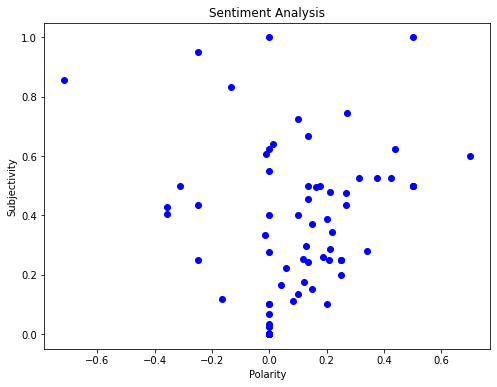

In [14]:
#Plot sentment analysis
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
  plt.scatter(df['Polarity'][i],df['Subjectivity'][i],color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

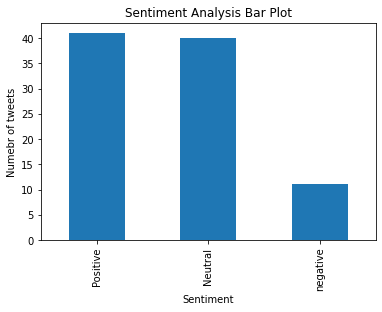

In [15]:
#Create bar chart to show the count of  positive,neutral,negative sentiments

df['Sentiment'].value_counts().plot(kind= 'bar')
plt.title('Sentiment Analysis Bar Plot')
plt.xlabel('Sentiment')
plt.ylabel('Numebr of tweets')
plt.show()

**Get Bitcoin prices per day from yahoo finance using yahoofinancial class**

In [16]:
btc_df= yf.download('BTC-USD',start='2021-01-01')
btc_df=btc_df.reset_index()
btc_df.tail(60)



[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
286,2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,57321.523438,36615791366
287,2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801
288,2021-10-16,61609.527344,62274.476562,60206.121094,60892.179688,60892.179688,34250964237
289,2021-10-17,60887.652344,61645.523438,59164.468750,61553.617188,61553.617188,29032367511
290,2021-10-18,61548.804688,62614.660156,60012.757812,62026.078125,62026.078125,38055562075
291,2021-10-19,62043.164062,64434.535156,61622.933594,64261.992188,64261.992188,40471196346
292,2021-10-20,64284.585938,66930.390625,63610.675781,65992.835938,65992.835938,40788955582
293,2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,62210.171875,45908121370
294,2021-10-22,62237.890625,63715.023438,60122.796875,60692.265625,60692.265625,38434082775
295,2021-10-23,60694.628906,61743.878906,59826.523438,61393.617188,61393.617188,26882546034


In [17]:
btc_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

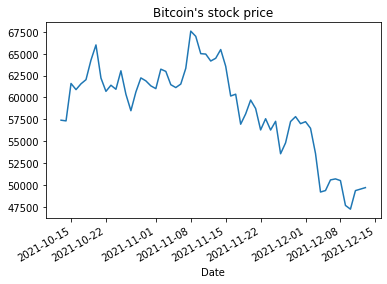

In [18]:
#plot bitcoin prices for last 2months
ticker = yf.Ticker('BTC-USD')
BTC_df  = ticker.history(period="2mo")
BTC_df ['Close'].plot(title="Bitcoin's stock price")

In [19]:
#Renaming columns to avoid intermittent issues with Date, Adj Close columns while data loading
btc_df.columns = ['TradeDate', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']
btc_df.head()

,TradeDate,Open,High,Low,Close,AdjClose,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [20]:
btc_df.columns

Index(['TradeDate', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


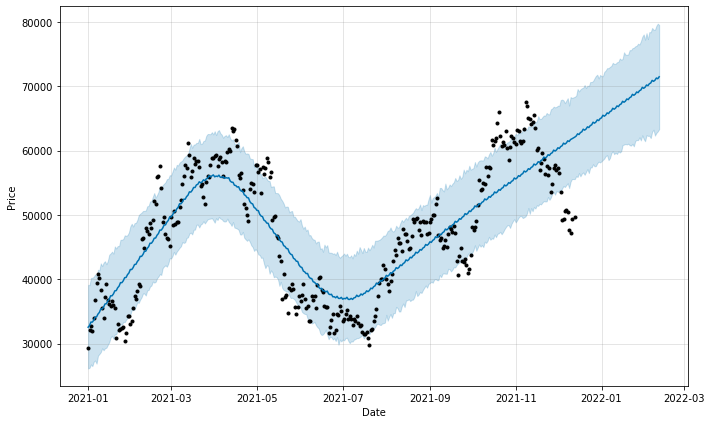

In [21]:
btc_df['ds'] =btc_df['TradeDate']
btc_df['y'] =btc_df['AdjClose']
model=Prophet()
model.fit(btc_df)
future = model.make_future_dataframe(periods=60)
future.tail()
forecast = model.predict(future)
forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
figure_1 = model.plot(forecast,   xlabel='Date', ylabel='Price')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


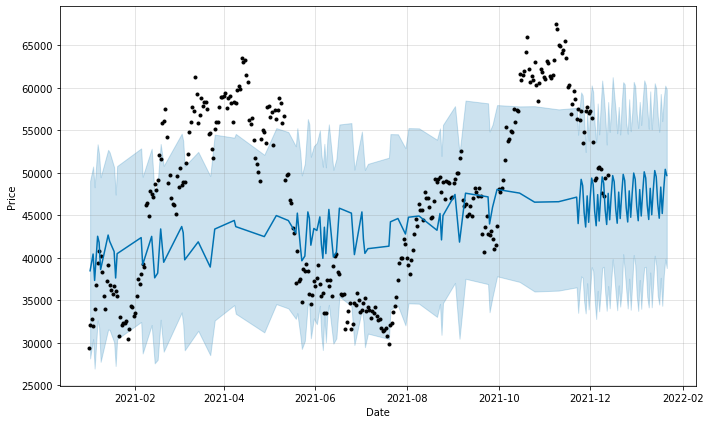

In [22]:
btctw_df = pd.merge(left=btc_df, right=df, left_on='TradeDate', right_on='createddate')
btctw_df
btctw_df['ds'] =btctw_df['TradeDate']
btctw_df['y'] =btctw_df['AdjClose']
model1=Prophet()
model1.fit(btctw_df)
future1 = model1.make_future_dataframe(periods=60)
forecast1 = model1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
figure_2 = model.plot(forecast1,   xlabel='Date', ylabel='Price')

In [23]:
df1 = forecast1[['ds','yhat','yhat_lower', 'yhat_upper']].tail(60)
df1.columns =['ds','yhat_tweetdate', 'yhat_upper_tweetdate', 'yhat_lower_tweetdate']
#forecast1.sort_values('ds',ascending=False)
df1

,ds,yhat_tweetdate,yhat_upper_tweetdate,yhat_lower_tweetdate
76,2021-11-23,44036.665204,33529.115297,54490.614617
77,2021-11-24,46903.659408,36036.934391,57630.372268
78,2021-11-25,49238.214241,37817.836679,59473.373108
79,2021-11-26,48509.262785,37656.935882,59120.050700
80,2021-11-27,45319.289311,34834.980360,56557.997960
81,2021-11-28,43630.195188,33466.926107,52464.752601
82,2021-11-29,47294.350984,37013.368911,57214.681769
83,2021-11-30,44184.602584,33931.227891,53778.383726
84,2021-12-01,47051.596788,36240.988779,58138.790692
85,2021-12-02,49386.151622,38909.206819,60298.643325


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


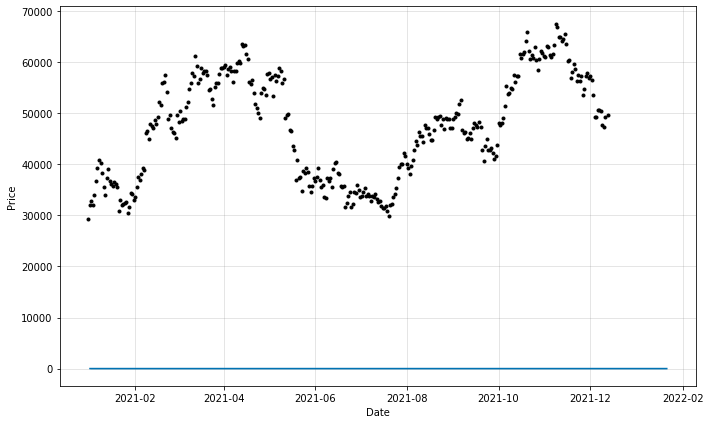

In [24]:
btctw_df1 = pd.merge(left=btc_df, right=df, left_on='TradeDate', right_on='createddate')
btctw_df1['ds'] =btctw_df1['TradeDate']
btctw_df1['y'] =btctw_df1['Polarity']
model2=Prophet()
model2.fit(btctw_df1)
future2 = model2.make_future_dataframe(periods=60)
forecast2 = model2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
figure_3 = model.plot(forecast2,   xlabel='Date', ylabel='Price')


In [25]:
df2 = forecast2[['ds','yhat','yhat_lower', 'yhat_upper']].tail(60)
df2.columns =['ds','yhat_polarity', 'yhat_lower_polarity', 'yhat_upper_polarity']
df2

,ds,yhat_polarity,yhat_lower_polarity,yhat_upper_polarity
76,2021-11-23,0.146514,-0.111409,0.381675
77,2021-11-24,0.010261,-0.235743,0.242083
78,2021-11-25,0.009804,-0.231988,0.230171
79,2021-11-26,-0.091324,-0.320258,0.149437
80,2021-11-27,0.045775,-0.181742,0.263881
81,2021-11-28,0.015030,-0.211486,0.246664
82,2021-11-29,0.028762,-0.198274,0.262444
83,2021-11-30,0.144797,-0.084349,0.383473
84,2021-12-01,0.008544,-0.198406,0.248413
85,2021-12-02,0.008087,-0.231119,0.252014


In [26]:
 merged_df = pd.merge(df1, df2, on=['ds']).tail(60)
 merged_df.sort_values('ds',ascending=False)


,ds,yhat_tweetdate,yhat_upper_tweetdate,yhat_lower_tweetdate,yhat_polarity,yhat_lower_polarity,yhat_upper_polarity
59,2022-01-21,49692.761828,38801.431693,59848.679641,-0.105059,-0.356964,0.119539
58,2022-01-20,50421.713284,39842.637485,60271.466651,-0.003932,-0.245410,0.228378
57,2022-01-19,48087.158450,37904.433419,58724.507294,-0.003475,-0.232427,0.226549
56,2022-01-18,45220.164246,34352.495789,56096.063450,0.132778,-0.098206,0.373513
55,2022-01-17,48329.912646,37651.922127,59288.241266,0.016743,-0.213775,0.237815
54,2022-01-16,44665.756850,34508.427381,54837.488978,0.003011,-0.224085,0.233914
53,2022-01-15,46354.850973,35559.796831,56687.965769,0.033756,-0.211359,0.282670
52,2022-01-14,49544.824447,39121.548168,59900.706786,-0.103342,-0.349039,0.131187
51,2022-01-13,50273.775903,40248.556841,60550.338817,-0.002215,-0.244900,0.224537
50,2022-01-12,47939.221070,37091.830914,57906.595860,-0.001758,-0.237559,0.244146
